
# Porfolio to maximum PnL
## Team: kuai le xin qiu
1.According stocksInfo and researchData to identify Pairs and calculate trading parameters.

2.According testData to backtest the Pairs portfolio with signals and dollarValue

3.Calculate the PnL of the backtested Pairs portfolio

## 1.Function Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web

# Download the font to display Chinese
!wget https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
CNFont = FontProperties(fname='/content/simhei.ttf')

# Yahoo Finance
!pip install yfinance
import yfinance as yf

# Google colab interactive table
%load_ext google.colab.data_table 
%matplotlib inline

# 20220202: Temp workaround for the pandas upgrade
!pip install --upgrade openpyxl

### Helper functions
# Display the stock info in Chinese or not
def useChinese(use=True):
  # return STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE
  if use:
    return 'hkStocksQuotesChi.xlsx', 'researchHKStocksAdjClosePxChi.csv', 'testHKStocksAdjClosePxChi.csv'

  else:
    return 'hkStocksQuotes.xlsx', 'researchHKStocksAdjClosePx.csv', 'testHKStocksAdjClosePx.csv'


STOCK_INFO_FILE, RESEARCH_AJD_CLOSE_FILE, TEST_AJD_CLOSE_FILE = useChinese(False)

CHART_SIZE_X, CHART_SIZE_Y = 12, 8
SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y = 8, 6


# Plot stock pair chart
def plotPair(df, stockA, stockB, sizeX, sizeY):
  ax1 = df[stockA].plot(label=stockA, legend=True, figsize = (sizeX, sizeY))
  ax1.set_ylim(df[stockA].min(), df[stockA].max())

  ax2 = df[stockB].plot(secondary_y=True, label=stockB, legend=True, figsize = (sizeX, sizeY))
  ax2.set_ylim(df[stockB].min(), df[stockB].max())

  ax1.legend(prop=CNFont, loc=2)
  ax2.legend(prop=CNFont, loc=1)

  plt.show()


# Plot all many Pairs at the same time
def plotManyPair(pairsDf):
  for index, row in pairsDf.iterrows():
      print('\n', index, ':', row['stockA'], 'vs', row['stockB'], '(', row['corr'], ')')
      plotPair(stocks, row['stockA'], row['stockB'], SMALL_CHART_SIZE_X, SMALL_CHART_SIZE_Y)


# Filter the correlated stock pairs with the THRESHOLD
def getCorrelatedPairs(stocksCorr, THRESHOLD=0.95):
  # filter the pairs with correlation values above the THRESHOLD
  highCorr = stocksCorr[((stocksCorr >= THRESHOLD) & (stocksCorr < 1))]
  highCorr = highCorr.unstack().sort_values(ascending=False).drop_duplicates()
  highCorr.dropna(inplace=True)
  highCorrDf = highCorr.to_frame().reset_index()
  highCorrDf.rename(columns = {'level_0':'stockA', 'level_1':'stockB', 0:'corr'}, inplace=True)

  # looks up the sectors for the stocksA and stockB
  cols = ['stockA', 'stockB', 'corr', 'sector_A', 'sector_B']
  pairsDf = highCorrDf.merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockA', right_on='shortName').merge(stocksFilteredInfo[['shortName', 'sector']], how='left', left_on='stockB', right_on='shortName', suffixes=('_A', '_B'))[cols]
  pairsDf['sameSector'] = (pairsDf['sector_A'] == pairsDf['sector_B'])
  
  return pairsDf


### back test related functions

# based on the reserch data to determind the trading params (Enter/Exit Points)
def researchTradingParams(researchData, stockA, stockB, threshold=0.05, dollarValue=10000):
  cols = [stockA, stockB]
  research_df = researchData[cols].copy()
  research_df.dropna(inplace = True)

  tradingParams = {}
  tradingParams['dollarValue'] = dollarValue

  # Calculate avgPxRatio for Exit (convergence)
  research_df['ratio'] = research_df[stockA] / research_df[stockB]
  avgPxRatio = research_df['ratio'].mean()
  tradingParams['avgPxRatio'] = avgPxRatio

  # Calculate shortA_longB_ratio for Entry (Divergence)
  shortA_longB_ratio = avgPxRatio * (1 + threshold)
  tradingParams['shortA_longB_ratio'] = shortA_longB_ratio

  # Calculate longA_shortB_ratio from Entry (Divergence)
  longA_shortB_ratio = avgPxRatio * (1 - threshold)
  tradingParams['longA_shortB_ratio'] = longA_shortB_ratio

  return tradingParams


# Determind the signal and dollarValue in the test data
# signal == -1: Long stockA Short stockB
# signal == 1: Short stockA Long stockB
# signal == 0: flat position
def backTest(testData, tradingParams, stockA, stockB):
  cols = [stockA, stockB]
  backTest_df = testData[cols].copy()
  backTest_df.dropna(inplace = True)

  # Get the tradingParams
  dollarValue = tradingParams['dollarValue']
  avgPxRatio = tradingParams['avgPxRatio']
  shortA_longB_ratio = tradingParams['shortA_longB_ratio']
  longA_shortB_ratio = tradingParams['longA_shortB_ratio']

  # Calculate the Price ratio in backTest_df
  backTest_df['pxRatio'] = backTest_df[stockA] / backTest_df[stockB]
  backTest_df['dollarValue'] = dollarValue
  
  # initialize the signal to 0
  backTest_df['signal'] = 0
  signal = 0

  # Determine the signal in each row of the backTest_df
  for index, row in backTest_df.iterrows():
    pxRatio = row['pxRatio']

    # mark signal = 1 if pxRatio > shortA_longB_ratio (Diverge outside the upper band)
    if pxRatio > shortA_longB_ratio:
      signal = 1

    # mark signal = -1 if pxRatio < longA_shortB_ratio (Diverge outside the lower band)
    elif pxRatio < longA_shortB_ratio:
      signal = -1

    else:
      # continue to mark signal = 1 if previous signal == 1 and pxRatio > avgPxRatio (Trade entered but not converge back yet)
      if signal == 1 and pxRatio > avgPxRatio:
        signal = 1

      # continue to mark signal = -1 if previous signal == -1 and pxRatio < avgPxRatio (Trade entered but not converge back yet)
      elif signal == -1 and pxRatio < avgPxRatio:
        signal = -1

      else:
        signal = 0

    backTest_df.loc[index, 'signal'] = signal

  return backTest_df


# determine pSignal and nSignal for up/down markers in plot
# pSignal and nSignal is for displaying the up/down markers in plotting chart only, they're not required for backtest calculation
def addSignalMarker(backTest_df):
  backTest_df['pSignal'] = np.where(backTest_df['signal'] == 1, backTest_df['pxRatio'], np.nan)
  backTest_df['nSignal'] = np.where(backTest_df['signal'] == -1, backTest_df['pxRatio'], np.nan)

  return backTest_df


# Combine the research and backtest for a Portfolio of Pairs
def researchAndBackTestPortfolio(pairsDf, researchData, testData, printOutput=True):
  pairsPortfolioBackTest = []

  for index, row in pairsDf.iterrows():
    stockA, stockB = row['stockA'], row['stockB']
    if printOutput: print(stockA, 'vs', stockB)
    tradingParams = researchTradingParams(researchData, stockA, stockB)
    pairsPortfolioBackTest.append(backTest(testData, tradingParams, stockA, stockB)[[stockA, stockB, 'signal', 'dollarValue']])

  return pairsPortfolioBackTest


# Download and import pairslib for calculating PnL
!wget https://github.com/kenwkliu/ideas/raw/master/colab/pairslib.py
import pairslib

# Load the stockInfo, researchData and testData
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/hkStocksQuotes.xlsx')
researchData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/researchHKStocksAdjClosePx.csv', index_col=0)
testData = pd.read_csv('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/testHKStocksAdjClosePx.csv', index_col=0)

--2022-02-05 13:13:36--  https://github.com/kenwkliu/ideas/raw/master/colab/data/simhei.ttf
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf [following]
--2022-02-05 13:13:36--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/simhei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [application/octet-stream]
Saving to: ‘simhei.ttf.1’

simhei.ttf.1        100%[===================>]   9.30M  --.-KB/s    in 0.05s   

2022-02-05 13:13:37 (205 MB/s) - ‘simhei.ttf.1’ saved [9751960/9751960]

The google.colab.data_table exte

## 2.Source of Stocks Data

In [ ]:
# Get the pre-downloaded (2020-Jul) all HK stocks information from yahoo and merged with stock sectors
# Pandas support reading Excel directly
stocksInfo = pd.read_excel('https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/data/' + STOCK_INFO_FILE)
stocksInfo

code        shortName  ...  forwardPE dividendDate
0      4333.HK          CISCO-T  ...        NaN          NaN
1      4335.HK          INTEL-T  ...        NaN          NaN
2      4338.HK      MICROSOFT-T  ...        NaN          NaN
3      9988.HK          BABA-SW  ...        NaN          NaN
4      0700.HK          TENCENT  ...  50.091408          NaN
...        ...              ...  ...        ...          ...
2730  83186.HK  CICCKRANECNET-R  ...        NaN          NaN
2731  83188.HK     CAM CSI300-R  ...        NaN          NaN
2732  83197.HK  CAM MSCI AINC-R  ...        NaN          NaN
2733  83199.HK  CSOP CTPBBOND-R  ...        NaN          NaN
2734  87001.HK    HUI XIAN REIT  ...   8.636364          NaN

[2735 rows x 70 columns]

In [ ]:
# list the unique industries names
industryNames = stocksInfo['industry'].unique()
print('Count:', len(industryNames))
print(industryNames)

Count: 23
['Information Technology' 'Financial' 'Telecommunications' 'Energy'
 'Food and Beverage' 'Real Estate Construction' 'Meida and Communications'
 'Medicine' 'Betting' 'Transportation, logistics and infrastructure'
 'Consumer Goods Manufacturing' 'Conglomerate' 'Retail' 'Electricity'
 'Automobile production and distribution' 'Industry'
 'Environmental protection' 'Consumer Service' 'Industrial Products'
 'Raw Materials' 'Index leveraged products' 'Fund' 'ETF']


In [ ]:
# list the unique sector names
sectorNames = stocksInfo['sector'].unique()
print('Count:', len(sectorNames))
print(sectorNames)

Count: 123
['Telecommunications Equipment' 'Semi-conductor' 'Technology and Software'
 'E-commerce and Internet' 'Online and Mobile Games'
 'State-owned China banks' 'China Telecom' 'International Insurance'
 'Bank' 'China Insurance' 'Other financial services' 'Oil and gas'
 'Alcoholic Beverages' 'Real Estate Development'
 'Media Entertainment Culture Publishing' 'Pharmaceutical'
 'China Properties' 'Macau Gaming' 'Public Transport' 'Toys'
 'Conglomerate' 'Biotechnology' 'Sporting Goods'
 'Gas and Public Utilities' 'Catering' 'Electric utility' 'Supermarket'
 'small and medium China banks' 'Automobile' 'Mobile phone related'
 'Machinery' 'Dairy related' 'Textile and Clothing' 'Healthcare'
 'Property Management and Agent' 'Auto sales' 'Infrastructure'
 'Agricultural and Fishery products'
 'Food and beverage Production and Wholesale' 'Local Telecom'
 'Real Estate Investment' 'Water utilities' 'Jewelry Watches' 'Snack Food'
 'Cement' 'Clothing Accessories' 'Photovoltaic Solar' 'Packaged f

In [ ]:
# Exploring the data 
# Look at the subset of useful columns and sort by largest marketCap
SELECTED_COLUMNS = ['code', 'quoteType', 'shortName', 'industry', 'sector', 'marketCap', 'regularMarketPreviousClose', 'averageDailyVolume10Day']

stocksInfo[SELECTED_COLUMNS].sort_values(by=['industry','marketCap'],ascending=False)

code quoteType  ... regularMarketPreviousClose averageDailyVolume10Day
291   1766.HK    EQUITY  ...                      3.410              24089768.0
26    0066.HK    EQUITY  ...                     38.400               3635701.0
273   0390.HK    EQUITY  ...                      3.940              18939387.0
324   1186.HK    EQUITY  ...                      6.240              10258910.0
243   1800.HK    EQUITY  ...                      4.500              16798366.0
...       ...       ...  ...                        ...                     ...
1818  1959.HK    EQUITY  ...                      0.370                 31000.0
1875  2339.HK    EQUITY  ...                      0.295                136725.0
1937  8126.HK    EQUITY  ...                      0.320                 87000.0
2066  1872.HK    EQUITY  ...                      0.123                493750.0
2243  1241.HK    EQUITY  ...                      0.100               3599250.0

[2735 rows x 8 columns]

## 3.Stock Selection

In [ ]:
# Before we look at the stock price correlation, select only liquid equity names for the trading purpose
# thus add a new colume 'turnover' 
stocksInfo['turnover'] = round(stocksInfo['regularMarketPreviousClose'] * stocksInfo['averageDailyVolume10Day'])

# Select only EQUITY and turnover is bigger than certain numbers
QUOTE_TYPE = 'EQUITY'
MIN_TURNOVER = 150000000  # 150 millions
SELECTED_COLUMNS = ['code', 'shortName', 'industry', 'sector', 'turnover']

stocksFilteredInfo = stocksInfo[(stocksInfo.quoteType == QUOTE_TYPE) & (stocksInfo.turnover > MIN_TURNOVER) & (stocksInfo.industry != 'ETF')].reset_index()
stocksFilteredInfo.sort_values(by=['turnover'], ascending=False)[SELECTED_COLUMNS]

code      shortName  ...                            sector      turnover
1    0700.HK        TENCENT  ...           Online and Mobile Games  1.094491e+10
0    9988.HK        BABA-SW  ...           E-commerce and Internet  6.289126e+09
26   0981.HK           SMIC  ...                    Semi-conductor  5.881712e+09
3    3690.HK      MEITUAN-W  ...           E-commerce and Internet  4.727324e+09
8    0388.HK           HKEX  ...          Other financial services  2.732908e+09
..       ...            ...  ...                               ...           ...
22   0960.HK  LONGFOR GROUP  ...           Real Estate Development  1.565513e+08
118  1765.HK       HOPE EDU  ...                   Support Service  1.548822e+08
116  6881.HK            CGS  ...  Chinese securities and financing  1.546935e+08
46   0762.HK   CHINA UNICOM  ...                     China Telecom  1.506411e+08
97   0728.HK  CHINA TELECOM  ...                     China Telecom  1.502325e+08

[138 rows x 5 columns]

In [ ]:
# Industry Distribution (diversity) with an interactive pie chart
import plotly.express as px

# Count the company names per industry
industryCount = stocksFilteredInfo[['industry', 'code']].groupby(['industry']).count().reset_index()
industryCount.rename(columns={'code' : 'count'}, inplace=True)

# Concat the company names per industry
industryStocks = stocksFilteredInfo[['industry', 'shortName']].groupby(['industry'])['shortName'].apply(', '.join).reset_index()

# Sum the marketCap and turnover per industry
industryDetails = stocksFilteredInfo[['industry', 'marketCap', 'turnover']].groupby(['industry']).sum().reset_index()

# Combine all in one dataframe
industryInfo = industryCount.merge(industryStocks, on='industry', how='left')
industryInfo = industryInfo.merge(industryDetails, on='industry', how='left')

fig = px.pie(industryInfo, values='count', names='industry', hover_name='shortName', title='Industry Distribution')
fig.show()

In [ ]:
# Industry Distribution table
industryInfo.sort_values(by=['count'], ascending=False)

industry  ...      turnover
7                                      Financial  ...  1.695750e+10
14                                      Medicine  ...  9.650277e+09
13                        Information Technology  ...  3.421692e+10
17                      Real Estate Construction  ...  5.637702e+09
6                                         Energy  ...  3.468583e+09
8                              Food and Beverage  ...  2.078364e+09
0         Automobile production and distribution  ...  3.544857e+09
19                            Telecommunications  ...  4.606182e+09
16                                 Raw Materials  ...  1.482049e+09
3                   Consumer Goods Manufacturing  ...  1.328616e+09
18                                        Retail  ...  1.441370e+09
12                                      Industry  ...  1.072249e+09
15                      Meida and Communications  ...  1.392047e+09
10                      Index leveraged products  ...  1.207266e+09
1                                        Betting  ...  8.613126e+08
4                               Consumer Service  ...  4.198875e+08
11                           Industrial Products  ...  2.238072e+08
9                                           Fund  ...  3.872289e+08
5                                    Electricity  ...  1.907916e+08
2                                   Conglomerate  ...  3.129450e+08
20  Transportation, logistics and infrastructure  ...  3.158948e+08

[21 rows x 5 columns]

In [ ]:
# download the daily stock price info (Open, High, Low, Close, Volume) from Yahoo
startDate = '2020-01-01'
allStockCodes = stocksFilteredInfo['code'].to_string(index=False).replace("\n", " ")

# auto_adjust=True: The closing price is adjusted
# Tencent 5 for 1 split: https://www.stocksplithistory.com/?symbol=TCEHY
data = yf.download(allStockCodes, start=startDate, group_by='ticker', auto_adjust=True)

columnNames = []
stocksDownload = []

for code, name in zip(stocksFilteredInfo['code'], stocksFilteredInfo['shortName']):
    if code in data:
      stocksDownload.append(data[code])
      columnNames.append(name)

[*********************100%***********************]  138 of 138 completed


In [ ]:
# Combine the stocks adjusted closes to one pandas data frame 
closes = [stock['Close'] for stock in stocksDownload]
stockCloses = pd.concat(closes, axis=1)
stockCloses.columns = columnNames

# To prevent lookahead bias, split the data into research period and test period
# The Pairs identification and the trading parameters (Entry / Exit) calculations will be based on research period
# Data in test period to for backtesting
researchData = stockCloses.loc['2020-01-01':'2020-7-31']
testData = stockCloses.loc['2021-01-01':]

# Export the data to csv file for downloading
#researchData.to_csv(RESEARCH_AJD_CLOSE_FILE, encoding='utf_8_sig')
#testData.to_csv(TEST_AJD_CLOSE_FILE, encoding='utf_8_sig')

researchData

BABA-SW     TENCENT  ...  FL2 CSOP HSI  LINK REIT
Date                                ...                         
2020-01-02  210.000000  380.297546  ...        10.400  75.700172
2020-01-03  212.000000  380.894257  ...        10.320  75.194260
2020-01-06  211.000000  375.325012  ...        10.160  74.642380
2020-01-07  212.600006  383.479950  ...        10.180  74.504417
2020-01-08  210.800003  379.899750  ...        10.040  74.228470
...                ...         ...  ...           ...        ...
2020-07-27  239.000000  518.586243  ...         7.625  55.029663
2020-07-28  244.600006  542.022339  ...         7.720  54.700710
2020-07-29  243.000000  540.027771  ...         7.770  55.687576
2020-07-30  244.800003  533.545410  ...         7.650  56.674446
2020-07-31  246.000000  532.548157  ...         7.645  56.533466

[144 rows x 138 columns]

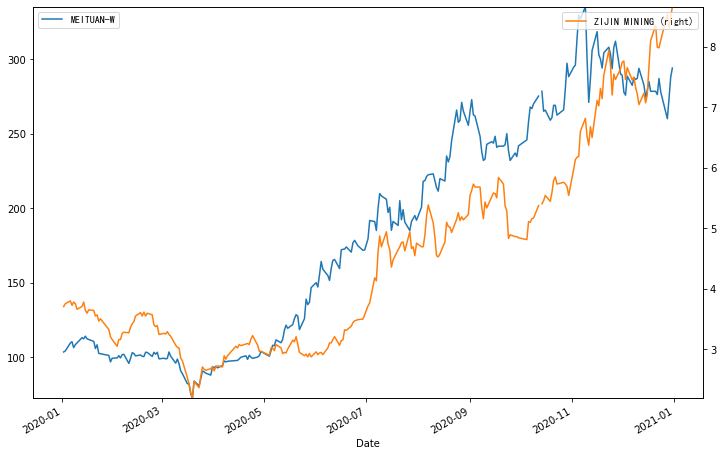

In [ ]:
# Pick 2 stocks price chart to to show the price correlation in research period
stockA = 'MEITUAN-W'
stockB = 'ZIJIN MINING'
plotPair(researchData, stockA, stockB, CHART_SIZE_X, CHART_SIZE_Y)

## 4.Pair Identifications

In [ ]:
# Run the price correlation for all stock Pair combinations in research period
stocksCorr = researchData.corr()
stocksCorr.style.background_gradient(cmap='coolwarm', axis=None)

In [ ]:
# filter the pairs with correlation values above the THRESHOLD
THRESHOLD = 0.85
pairsDf = getCorrelatedPairs(stocksCorr, THRESHOLD)

pairsDf.round(4)

stockA  ... sameSector
0       ZIJIN MINING  ...      False
1        XINYI SOLAR  ...      False
2           XIAOMI-W  ...      False
3         YIHAI INTL  ...      False
4          MEITUAN-W  ...      False
..               ...  ...        ...
748             HKTV  ...      False
749  CHINA DONGXIANG  ...      False
750       PETROCHINA  ...      False
751    CHINA SHENHUA  ...      False
752   HANG SENG BANK  ...      False

[753 rows x 6 columns]

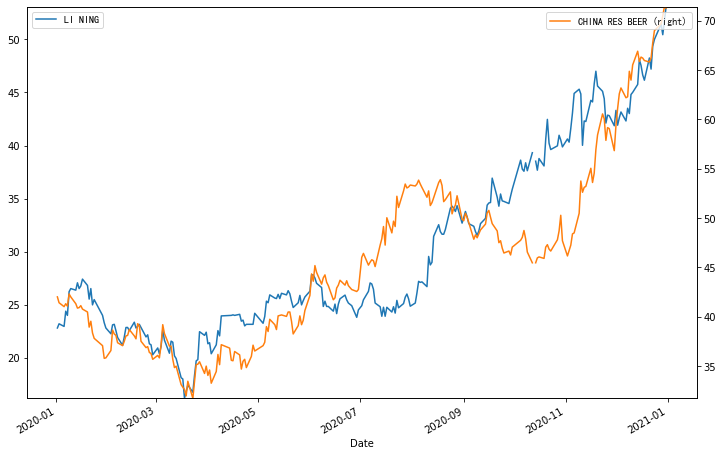

In [ ]:
# Pick a stock pair price chart to to show the price correlation
selected_pair = 701

PAIR_STOCK_A = pairsDf.loc[selected_pair]['stockA']
PAIR_STOCK_B = pairsDf.loc[selected_pair]['stockB']
plotPair(researchData, PAIR_STOCK_A, PAIR_STOCK_B, CHART_SIZE_X, CHART_SIZE_Y)

# Plot all the correlated Pairs with same sector
#plotManyPair(pairsDf[(pairsDf.sameSector == True)])

## 5.Trading Parameters (Entry/Exit Point)

In [ ]:
# Running the price ratio which represent the relative price value
# Calculate the stock price ratios of (Stock A / Stock B) over the research period
pairResearchData = researchData[[PAIR_STOCK_A, PAIR_STOCK_B]].copy()

AB_stock = PAIR_STOCK_A + " / " + PAIR_STOCK_B
pairResearchData[AB_stock] = pairResearchData[PAIR_STOCK_A] / pairResearchData[PAIR_STOCK_B]

pairResearchData[[PAIR_STOCK_A, PAIR_STOCK_B, AB_stock]]

LI NING  CHINA RES BEER  LI NING / CHINA RES BEER
Date                                                           
2020-01-02  22.817587       42.009098                  0.543158
2020-01-03  23.213554       41.416035                  0.560497
2020-01-06  22.966076       41.020649                  0.559866
2020-01-07  24.401453       41.317184                  0.590588
2020-01-08  24.005487       41.070072                  0.584501
...               ...             ...                       ...
2020-12-24  49.987457       68.987976                  0.724582
2020-12-28  51.432755       69.682823                  0.738098
2020-12-29  50.435993       70.476929                  0.715638
2020-12-30  51.781620       71.419922                  0.725030
2020-12-31  53.077408       71.271042                  0.744726

[249 rows x 3 columns]

Average BUY/SELL price ratio of LI NING / CHINA RES BEER in research period: 0.649888378584455
Entry Point (Divergence) Signal -1 (Long A Short B): Long LI NING and Short CHINA RES BEER when the BUY/SELL price ratio < 0.6173939596552322
Entry Point (Divergence) Signal +1 (Short A Long B): Short LI NING and Long CHINA RES BEER when the BUY/SELL price ratio > 0.6823827975136778
Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio:  0.649888378584455


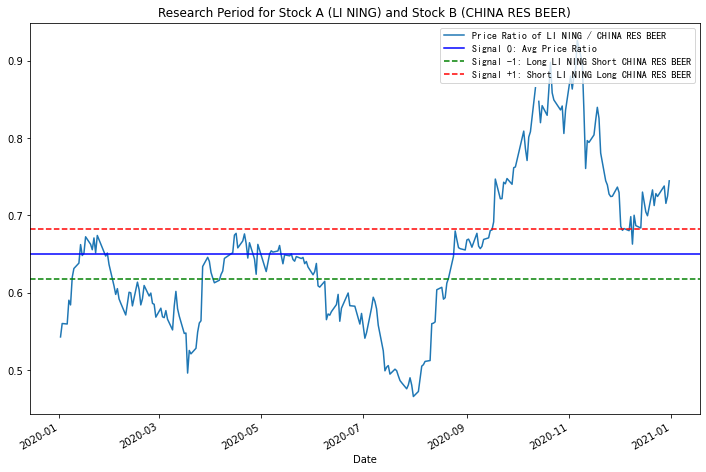

In [ ]:
# Calculate the trading parameters from research period
PX_RATIO_THRESHOLD = 0.05
tradingParams = researchTradingParams(pairResearchData, PAIR_STOCK_A, PAIR_STOCK_B, PX_RATIO_THRESHOLD)

avgPxRatio = tradingParams['avgPxRatio']
longA_shortB_ratio = tradingParams['longA_shortB_ratio']
shortA_longB_ratio = tradingParams['shortA_longB_ratio']

print("Average BUY/SELL price ratio of", AB_stock, "in research period:", avgPxRatio)

# Plot the averge price ratio in research period
labelTitle = 'Research Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
labelPriceRatio = 'Price Ratio of {} / {}'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pairResearchData[AB_stock].plot(title=labelTitle, label=labelPriceRatio, legend=True, figsize=(CHART_SIZE_X, CHART_SIZE_Y))

labelAvgPrice = 'Signal 0: Avg Price Ratio ' 
plt.axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
plt.legend(loc ='upper right')

labelLongAShortB = 'Signal -1: Long ' + PAIR_STOCK_A + ' Short ' + PAIR_STOCK_B
plt.axhline(y=longA_shortB_ratio, label=labelLongAShortB, color='g', linestyle='--')

labelShortALongB = 'Signal +1: Short ' + PAIR_STOCK_A + ' Long ' + PAIR_STOCK_B
plt.axhline(y=shortA_longB_ratio, label=labelShortALongB, color='r', linestyle='--')

plt.legend(loc ='upper right', prop=CNFont)

print("Entry Point (Divergence) Signal -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", longA_shortB_ratio)
print("Entry Point (Divergence) Signal +1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", shortA_longB_ratio)
print("Exit Poiont (Convergence) Signal 0: Unwind the open Long/Short positions at average price ratio: ", avgPxRatio)

## 6.Backtesting

Entry Point (Divergence) Signal == -1 (Long A Short B): Long LI NING and Short CHINA RES BEER when the BUY/SELL price ratio < 0.6173939596552322
Entry Point (Divergence) Signal == 1 (Short A Long B): Short LI NING and Long CHINA RES BEER when the BUY/SELL price ratio > 0.6823827975136778
Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio:  0.649888378584455
------------------------------------------------------------------------------------------------------------
Use the default $10,000 when entering the trade (i.e. create $10,000 long and $10,000 short exposure at the same time)
Assume no transaction cost, perfect execution (can long/short at equal dollar amount), no short borrowing cost)
*** PnL: -6954.007048296124


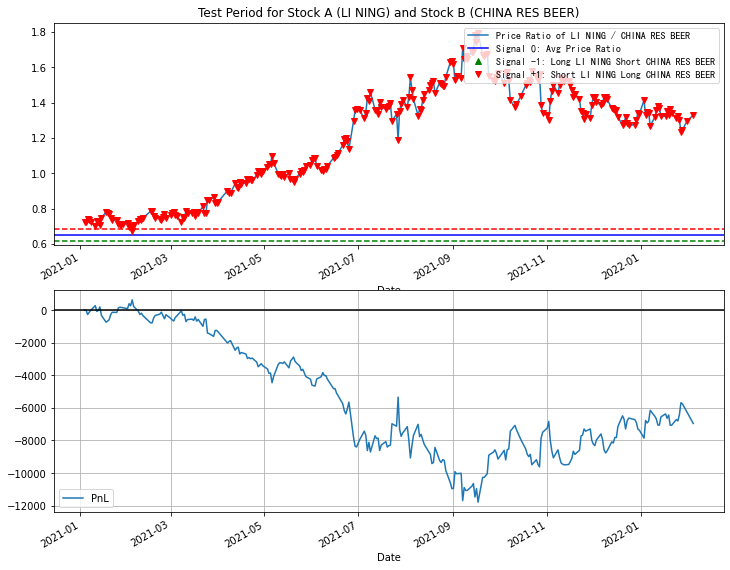

In [ ]:
print("Entry Point (Divergence) Signal == -1 (Long A Short B): Long", PAIR_STOCK_A, "and Short", PAIR_STOCK_B, "when the BUY/SELL price ratio <", tradingParams['longA_shortB_ratio'])
print("Entry Point (Divergence) Signal == 1 (Short A Long B): Short", PAIR_STOCK_A, "and Long", PAIR_STOCK_B, "when the BUY/SELL price ratio >", tradingParams['shortA_longB_ratio'])
print("Exit Poiont (Convergence) Signal == 0 : Within the above range or Unwind the open Long/Short positions at average price ratio: ", tradingParams['avgPxRatio'])
print("------------------------------------------------------------------------------------------------------------")
# Backtest a Pair in test period
backTest_df = backTest(testData, tradingParams, PAIR_STOCK_A, PAIR_STOCK_B)

# Calcuate the PnL in test period
print("Use the default $10,000 when entering the trade (i.e. create $10,000 long and $10,000 short exposure at the same time)")
print("Assume no transaction cost, perfect execution (can long/short at equal dollar amount), no short borrowing cost)")
pnl, pnl_df = pairslib.calcPnl(backTest_df)
print("*** PnL:", pnl)
print("==================================")
#cols = [PAIR_STOCK_A, PAIR_STOCK_B, 'pxRatio', 'signal', 'longValue', 'shortValue', 'longPos', 'shortPos', 'longPnl', 'shortPnl', 'pnl', 'totalPnl']
#pnl_df[cols].round(4)


# Plot the backtest and PnL results
pnl_df = addSignalMarker(pnl_df)
fig, axes = plt.subplots(2, 1)

labelTitle = 'Test Period for Stock A ({}) and Stock B ({})'.format(PAIR_STOCK_A, PAIR_STOCK_B)
pnl_df.pxRatio.plot(ax=axes[0], title=labelTitle, label=labelPriceRatio, legend=True)
axes[0].axhline(y=avgPxRatio, label=labelAvgPrice, color='b', linestyle='-')
pnl_df.nSignal.plot(ax=axes[0], label=labelLongAShortB, color='g', linestyle='None', marker='^', legend=True)
pnl_df.pSignal.plot(ax=axes[0], label=labelShortALongB, color='r', linestyle='None', marker='v', legend=True)

axes[0].axhline(y=longA_shortB_ratio, color='g', linestyle='--')
axes[0].axhline(y=shortA_longB_ratio, color='r', linestyle='--')
axes[0].legend(loc ='upper right', prop=CNFont)

pnl_df.totalPnl.plot(ax=axes[1], label='PnL', legend=True, figsize=(CHART_SIZE_X, 10), grid=True)
axes[1].axhline(y=0, color='black', linestyle='-')

In [ ]:
# Selects the Pairs with same sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == True)]
print("Total pairs with same sectors for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# look at one of the pairs backtest results
# Each backtested Pairs is a dataframe with these columns (Date, stockA, stockB, signal, dollarValue)
#pairsPortfolioBackTest[0]

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

Total pairs with same sectors for backtesting: 36
----------------------------------------------------------
BANK OF CHINA vs ICBC ---> $ -239.59937125480428
HSBC HOLDINGS vs HANG SENG BANK ---> $ 389.61509111785745
GREATWALL MOTOR vs BYD COMPANY ---> $ 3440.757814503275
LI NING vs ANTA SPORTS ---> $ -5872.785628793978
PETROCHINA vs CNOOC ---> $ -1830.8758118542955
CHINA UNICOM vs CHINA TELECOM ---> $ -2022.3281215568259
CHINA YOUZAN vs MEITUAN-W ---> $ -5811.04399962156
SINOPEC CORP vs PETROCHINA ---> $ -886.8225642752477
WEIGAO GROUP vs MICROPORT ---> $ 334.9375672850756
CSC vs HKEX ---> $ -1310.4421745198906
CHINA LIT vs MEITUAN-W ---> $ 3522.6667312951076
ICBC vs ABC ---> $ 1107.5182432066358
KINGSOFT vs KINGDEE INT'L ---> $ 1395.7946211231874
CGS vs CITIC SEC ---> $ -458.12459171773116
PING AN vs CPIC ---> $ -558.714977736714
CCB vs ABC ---> $ 1281.8161702626476
GEELY AUTO vs GREATWALL MOTOR ---> $ -1629.4690980145451
CANSINOBIO-B vs PA GOODDOCTOR ---> $ -4450.415866867496
BYD COM

stockA          stocksB          Pnl
0     BANK OF CHINA             ICBC  -239.599371
1     HSBC HOLDINGS   HANG SENG BANK   389.615091
2   GREATWALL MOTOR      BYD COMPANY  3440.757815
3           LI NING      ANTA SPORTS -5872.785629
4        PETROCHINA            CNOOC -1830.875812
5      CHINA UNICOM    CHINA TELECOM -2022.328122
6      CHINA YOUZAN        MEITUAN-W -5811.044000
7      SINOPEC CORP       PETROCHINA  -886.822564
8      WEIGAO GROUP        MICROPORT   334.937567
9               CSC             HKEX -1310.442175
10        CHINA LIT        MEITUAN-W  3522.666731
11             ICBC              ABC  1107.518243
12         KINGSOFT    KINGDEE INT'L  1395.794621
13              CGS        CITIC SEC  -458.124592
14          PING AN             CPIC  -558.714978
15              CCB              ABC  1281.816170
16       GEELY AUTO  GREATWALL MOTOR -1629.469098
17     CANSINOBIO-B    PA GOODDOCTOR -4450.415867
18      BYD COMPANY       GEELY AUTO -4160.699430
19             ICBC              CCB   -24.426741
20       CHINA LIFE              NCI   904.300754
21              CSC    EB SECURITIES   210.632984
22        MEITUAN-W          BABA-SW -2461.213764
23    HANSOH PHARMA     INNOVENT BIO   575.727554
24    BOC HONG KONG   HANG SENG BANK   495.785538
25     CHINA YOUZAN        CHINA LIT  2174.351726
26        MICROPORT      WUXI APPTEC   549.594517
27    BANK OF CHINA              ABC   703.702104
28     SINOPEC CORP            CNOOC  1617.298955
29     WEIGAO GROUP     CANSINOBIO-B -1166.495602
30       GEELY AUTO   DONGFENG GROUP  1549.185481
31    KINGDEE INT'L  CHINASOFT INT'L  2966.442713
32        CHINA LIT          BABA-SW -2968.350856
33              CCB    BANK OF CHINA   205.152107
34            SUNAC   CHINA OVERSEAS -7935.691001
35     WEIGAO GROUP    PA GOODDOCTOR  -313.335255

In [ ]:
# Selects the Pairs with different sectors into the portfolio
selectedPairsDf = pairsDf[(pairsDf.sameSector == False)]
print("Total pairs with different sectors for backtesting:", len(selectedPairsDf))
print('----------------------------------------------------------')

# Research the trading params and back test the selected Pairs in test period
pairsPortfolioBackTest = researchAndBackTestPortfolio(selectedPairsDf, researchData, testData, printOutput=False)

# Calcuate the PnL of the Pairs portfolio
pnl, pnlDf = pairslib.calcPortfolio(pairsPortfolioBackTest)
pnlDf

Total pairs with different sectors for backtesting: 717
----------------------------------------------------------
ZIJIN MINING vs MAN WAH HLDGS ---> $ -816.69888498009
XINYI SOLAR vs XINYI GLASS ---> $ 4783.269032135463
XIAOMI-W vs MAN WAH HLDGS ---> $ -2673.1670778075595
YIHAI INTL vs CG SERVICES ---> $ -2332.2921926983654
MEITUAN-W vs TECHTRONIC IND ---> $ 3684.6057349989587
GREATWALL MOTOR vs XINYI SOLAR ---> $ -1698.3998362285301
XINYI SOLAR vs WUXI BIO ---> $ 6582.5520092711
MENGNIU DAIRY vs ZIJIN MINING ---> $ -1156.3869874871252
MAN WAH HLDGS vs MENGNIU DAIRY ---> $ 2648.149312743014
MAN WAH HLDGS vs WUXI BIO ---> $ 2405.1881461431385
XINYI GLASS vs XIAOMI-W ---> $ -2100.549434192264
TENCENT vs MEITUAN-W ---> $ 638.4258979430588
LI NING vs XINYI GLASS ---> $ -418.77166172721445
XIAOMI-W vs WUXI BIO ---> $ -1181.6610130648642
LI NING vs WUXI BIO ---> $ -1355.4758339083164
KINGDEE INT'L vs CHINA YOUZAN ---> $ -3892.5420344308895
WUXI APPTEC vs KINGDEE INT'L ---> $ 5682.6261358319

stockA         stocksB          Pnl
0       ZIJIN MINING   MAN WAH HLDGS  -816.698885
1        XINYI SOLAR     XINYI GLASS  4783.269032
2           XIAOMI-W   MAN WAH HLDGS -2673.167078
3         YIHAI INTL     CG SERVICES -2332.292193
4          MEITUAN-W  TECHTRONIC IND  3684.605735
..               ...             ...          ...
712             HKTV     HUABAO INTL -6433.304428
713  CHINA DONGXIANG       CITIC SEC   315.449486
714       PETROCHINA   BANK OF CHINA -1851.769186
715    CHINA SHENHUA   KINGDEE INT'L  7672.067940
716   HANG SENG BANK            ICBC  -428.845382

[717 rows x 3 columns]

Because our sector result which are same doesn't run well, so we only choose the different sector as our choice, and the result is 287407 USD, this result is good for our prediction.